# Homework #7: Due October 28th, 2021, 11:59pm
## Hamiltonian Monte Carlo for Bayesian Logistic Regression

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2021**

**Name: Jiahui Tang**

**Students collaborators: Shi Le Wong, Xin Zeng**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import PolynomialFeatures
from pymc3 import Model
import pymc3 as pm
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5
        
    i = 0
    
    for model in models:
        yy = model.predict(xx)  
        yy = yy.reshape((n, n))

        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)
        
        i += 1
        
    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
        
    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Bayesian_logistic_regression:
    def __init__(self, intercept, slopes):
        self.intercept = intercept
        self.slopes = slopes

    def predict(self, x):
        y = sigmoid(x.dot(self.slopes) + self.intercept)
        return (y > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return sigmoid(x.dot(self.slopes) + self.intercept)

## Problem Description: Inference for Bayesian Logistic Regression Models
In In-Class Exercise 10.13, we studied the problem of how to evaluate the classification probabilites outputed by a Logistic Regression model using calibration plots. Calibration plots are computed using observed data (data that is part of or similar to our training set). In this homework, we evaluate the usefulness of the predictive uncertainties Logistic Regression models and Bayesian Logistic Regression models for test data that are dissimilar to our training data. These test data points are called ***out of distribution (OOD) points***. Just as in Homework #2, we want the predictive uncertainties from our models to help us distinguish ***in-distribution*** test data (test data that are similar to data on which we trained our model) and OOD test data. Again, in many safety-critical applications of ML, we want human-experts to override model decisions if the model is operating on extremely unfamiliar data.


### Part I: Interpreting the Classification Probabilites of Logistic Regression as Uncertainties

**Exercise 1: (Classifying OOD MNIST Digits)** In In-Class Exercise 10.13, we interpreted the output of a Logistic Regression model - the classification probability - as an indicator of the confidence of the model when it is classifying a specific data point (e.g. when the probability is close to 0.5, we say that the model is not confident in classifying the data point as class 1 or 0). Explain why this is a reasonable interpretation of the classification probability. 

In this Exercise, build a Logistic Regression model to distinguish between digital images of handwritten digits (this is the MNIST dataset):

` LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)`

For simplicity, we only look at images of digits: 1 and 6. 

In this dataset, the classes are balanced (we take 600 images of each digit). Report the accuracy of your trained classifier, based on this, decide whether or not this is a good model.

Next, for the predefined set of six test images,
`test_point_1`, ..., `test_point_6`,
report the classification probabiliy for each image under your trained model. Interpreting these probabilities as uncertainty, i.e. model confidence, do these predictive uncertainties make sense? **Hint:** compare the predictive uncertainties to the visualizations of these test images.

So is this classifier a good model? Does your analysis of the model's performance via its predictive accuracy agree with your analysis of the model's performance via its predictive uncertainties? Conclude whether or not you would feel comfortable using this model in a real-life setting?

In [3]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


In [4]:
# Pick out two classes of digits: 1, 6 and take a subset of samples
X_subset = X[((y == '1') | (y == '6'))][0:600]
y_subset = y[((y == '1') | (y == '6'))][0:600]

# Encode the label '1' with y=1, and the label '6' with y=0
y_subset[y_subset == '1'] = '1'
y_subset[y_subset == '6'] = '0'
y_subset = y_subset.astype(int)


In [5]:
# Randomize our data
random_state = check_random_state(0)
permutation = random_state.permutation(X_subset.shape[0])
X_subset = X_subset.iloc[permutation].values
y_subset = y_subset.iloc[permutation].values
X_subset = X_subset.reshape((X_subset.shape[0], -1))

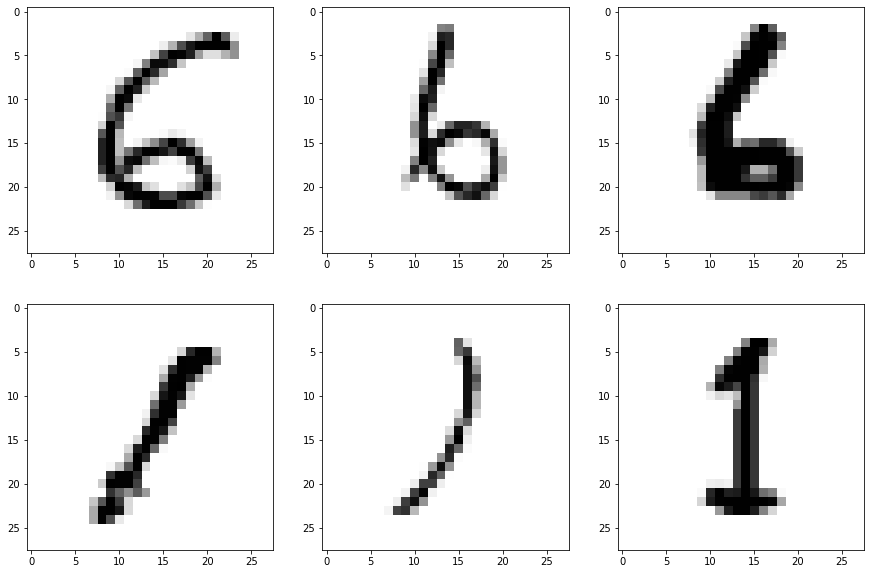

In [6]:
# Visualize some samples from the training dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    ax[0, i].imshow(X_subset[y_subset == 0][i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax[1, i].imshow(X_subset[y_subset == 1][i].reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [7]:
# Test images for evaluating your classifier
test_point_1 = X_subset[y_subset == 0][10]
test_point_2 = X_subset[y_subset == 1][10]
test_point_3 = X[y=='3'].iloc[20].values
test_point_4 = np.random.normal(200, 10, size=(28 * 28, ))
test_point_5 = test_point_2 + np.random.normal(300, 10, size=(28 * 28, )) - test_point_1
test_point_6 = test_point_2 + test_point_1 + np.random.normal(100, 10, size=(28 * 28, ))


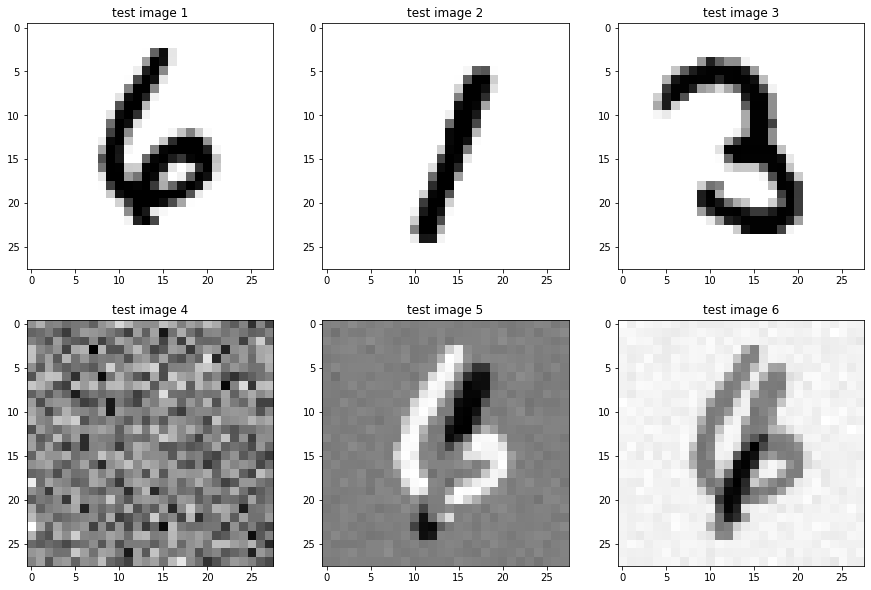

In [8]:
# Visualize some samples from the test dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(test_point_1.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 0].set_title('test image 1')
ax[0, 1].imshow(test_point_2.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 1].set_title('test image 2')
ax[0, 2].imshow(test_point_3.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[0, 2].set_title('test image 3')
ax[1, 0].imshow(test_point_4.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 0].set_title('test image 4')
ax[1, 1].imshow(test_point_5.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 1].set_title('test image 5')
ax[1, 2].imshow(test_point_6.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
ax[1, 2].set_title('test image 6')
plt.show()

In [9]:
logreg = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
logreg.fit(X_subset, y_subset)
print('Accuracy of logistic regression on training dataset is : %.4f'%logreg.score(X_subset, y_subset))

Accuracy of logistic regression on training dataset is : 0.9950


In [10]:
test_lst = [test_point_1, test_point_2,test_point_3,test_point_4,test_point_5,test_point_6]

prob = np.vstack([logreg.predict_proba(i.reshape(1, -1)) for i in test_lst])
pred = np.vstack([logreg.predict(i.reshape(1,-1)) for i in test_lst])
df = pd.DataFrame(prob, columns=['Prob of 6 (CLASS 0)', 'Prob of 1 (CLASS 1)'])
df['prediction'] = pred

df

,Prob of 6 (CLASS 0),Prob of 1 (CLASS 1),prediction
0,0.998424,0.001576,0
1,0.001475,0.998525,1
2,0.168727,0.831273,1
3,0.996468,0.003532,0
4,0.008245,0.991755,1
5,0.934672,0.065328,0


<font color="darkblue">
    
**Interpretation:**
    
    
1. *Explain why this is a reasonable interpretation of the classification probability.*
    
When the classification probability is high in one class, e.g. 0.9, the model showing the probability of the obervation being in that class is high, which means that our model is pretty confident in classifying this observation. 
However, if the classification probability is around 0.5, it means the model think it is equally likely for this prediction to be either in class 0 or class 1. The model is like making a random guess when classifying this observation, and not confident in classifying the data point as class 1 or 0. Thus this is a reasonable interpretation of the classification probability.
    
2. *Model Interpretation*
    
Our model achieves 99.5% accuracy, which seems to be highly efficient and accurate. However, as the model is only trained on number 1 and 6, when it comes to out of distribution (OOD) test data points, it may not achieve same accuracy.
    
Looking at predictions on test data points. 
* It classifies point 1 as `6`, point 2 as `1` all with almost 99.8% probability. This makes sense as both of them are 6 and 1 points taking from x subset.
* It classifies point 3 as `1`, point 4 as `6` with also high confidence. This doesn't make sense. As point 3 is an image with number `3`, and point 4 is produced by random normal noise.
* It further classifes point 5 as `1` and point 6 as `6` with 99% and 93% probability each. However, point 5 is made by taking test point 1 off from test point 2; and point 6 is made by adding test point 1 on top of test point 2, both of them has number 1 and 6 overlays each other.
* All of these predictions are with high probability and high confidence. However, these predictive uncertainties make no sense, by comparing the predictive uncertainties to the visualizations of these test images.

Thus this classifier could not be considered a good model when comes to OOD data. Our analysis of the model's performance via its predictive accuracy does not always agree with the analysis of the model's performance via its predictive uncertainties. The accuracy is quite high (99%), however, the predictive uncertainty is not something we expected when it comes to OOD data. We expect it to be less certain when facing something they never see before, but it turns out to be quite certain, and also making wrong prediction.
I would not feel comfortable using this model in a real-life setting, it could give certain prediction even when facing something we never seen before, without giving us enough warning of these new types of data input.
    
As said above in question background, we want the predictive uncertainties from our models to help us distinguish in-distribution test data (test data that are similar to data on which we trained our model) and OOD test data. In many safety-critical applications of ML, we want human-experts to override model decisions if the model is operating on extremely unfamiliar data. This model doesn't seem to give any signal warning us if the model is operating on extremely unfamiliar data, but instead give us a quite certain prediction. Thus, I don't feel very safe to deploy this model in real life setting.

**Exercise 2: (Classifying OOD Data for a Toy Dataset)** In this Exercise, build a Logistic Regression model to distinguish between two classes in our toy classification dataset:

` LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)` 

In this dataset, the classes are balanced (we have 100 points in each class). Report the accuracy of your trained classifier, based on this, decide whether or not this is a good model.

Next, for the predefined set of test points,
`test_points`,
report the classification probabiliy for each test point under your trained model. Interpreting these probabilities as uncertainty, i.e. model confidence, do these predictive uncertainties make sense? **Hint:** compare the predictive uncertainties to the visualizations of these test points, identify which of these test points are in-distribution and which ones are OOD.

Relate your analysis of the behaviour of Logistic Regression on this toy dataset to its performance on MNIST. Can you come up with some hypotheses for exactly when the classification probability indicates an inappropriate amount of certainty when predicting on test points?

In [11]:
# Generate a toy dataset for classification
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)


In [12]:
# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]


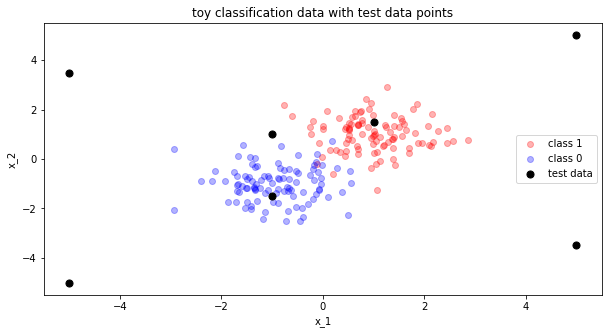

In [13]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)

logreg.fit(x_train, y_train)
print('Accuracy of logistic regression on training dataset is : %.4f'%logreg.score(x_train, y_train))
print('Accuracy of logistic regression on training dataset is : %.4f'%logreg.score(x_test, y_test))



Accuracy of logistic regression on training dataset is : 0.9750
Accuracy of logistic regression on training dataset is : 0.9500


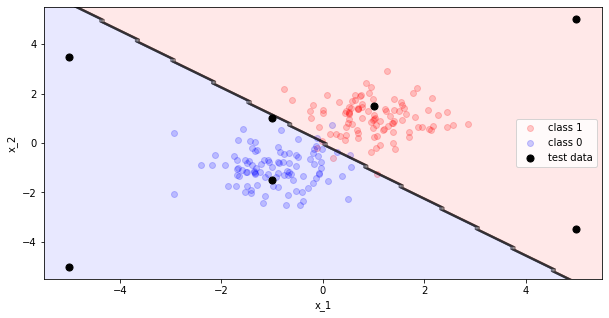

In [15]:
# Plot the decision boundary for the learned model
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = plot_decision_boundary(x, y, [logreg], ax, poly_degree=1, test_points=test_points, shaded=True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()

In [16]:
prob = np.vstack([logreg.predict_proba(np.array(i).reshape(1, -1)) for i in test_points])
pred = np.vstack([logreg.predict(np.array(i).reshape(1,-1)) for i in test_points])

df = pd.DataFrame(prob, columns=['Prob of CLASS 0', 'Prob of CLASS 1'])
df['prediction'] = pred
df.index = [str(i) for i in test_points]

df


,Prob of CLASS 0,Prob of CLASS 1,prediction
"(-5, -5)",1.000000e+00,7.164770e-11,0
"(-5, 3.5)",9.915977e-01,8.402293e-03,0
"(5, 5)",7.483858e-11,1.000000e+00,1
"(5, -3.5)",8.773210e-03,9.912268e-01,1
"(-1, 1)",5.782342e-01,4.217658e-01,0
"(-1, -1.5)",9.969291e-01,3.070869e-03,0
"(1, 1.5)",3.207193e-03,9.967928e-01,1


<font color="darkblue">
    
**Interpretation:**
    
   
Our model achieves 97% and 95% accuracy in training and testing set, which seems to be highly efficient and accurate, it seems to be a fairly good model. 
    
Looking at predictions on pre-defined test data points. 
* It classifies 4 OOD data point `(-5, -5)`,`(-5, 3.5)`,`(5, 5)`, `(5, -3.5)` with high certainty and confidence.
* However, it classifiy in-distribution data point `(-1, 1)` with low confidence, as it sits on the decision boundary.
    
    
The uncertainty doesn't make sense because the OOD test points might be classified by the logistic model with high confidency, while in-distribution test points might be classified with low confidency. 
However, if we dive deep into the visualization of our data and test points, it is reasonable to hypothesize that the test points near the decision boundary will be classified with low confidency, while points away from the dicision boundary will be classified with high confidency. 

If the OOD data have some real life meaning, and needs to have higher uncertainty, then this classifier could not be considered a good model when comes to OOD data. Our analysis of the model's performance via its predictive accuracy does not always agree with the analysis of the model's performance via its predictive uncertainties. The accuracy is quite high (98%), however, the predictive uncertainty is not something we expected when it comes to OOD data. We expect it to be less certain when facing something they never see before, but it turns out to be quite certain.
    
However, if there's no real life meaning but we only want to classify points by a hyperplane, then this certainty is totally fine, as these OOD points are further away from decision boundary.

Therefore, if a point is near the decision boundary, the classification probability might be appropriate to indicate uncertainty. However, if a point is far away from the decision boundary, it could be inappropriate to indicate uncertainty using classification probability. We need a second thought with a grain of salt here, to look into downstream task and consider underlying real life meaning of these OOD data points.

---

### Part II: Interpreting the Uncertainties of Bayesian Logistic Regression

**Exercise 3: (Classifying OOD Data for a Toy Dataset with Bayesian Logistic Regression)** 
In Exercise 2 and 3, we examined one source of uncertainty from a logistic model: the classification probability. There is another source of uncertainty: uncertainty over the model itself (which decision boundaries can fit the dataset).

Use your implementation of HMC from In-Class Exercise 10.20 to sample from the posterior of the following Bayesian Logistic Regression model for our toy dataset:

\begin{align}
w_i &\sim \mathcal{N}(0, 10)\\
Y^{(n)} &\sim Ber(\text{sigm}(w_2 X_1^{(n)} + w_1 X_2^{(n)} + w_0))
\end{align}

where $w_i$, $Y^{(n)}$, $X_i^{(n)}$ are real scalar valued random variables, and where the data consists of the observations $(x_1^{(n)}, x_2^{(n)}, y^{(n)})$ in our toy dataset $\mathcal{D}$.

We suggest using the following settings for your HMC:

```python
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = np.hstack((logistic.coef_.flatten(), logistic.intercept_))
position_init = position_init.reshape((1, 3))
#leap-frog step size
step_size = 1e-1
#leap-frog steps
leapfrog_steps = 20
#number of total samples after burn-in
total_samples = 5000
#percentage of samples to burn
burn_in = 0.1
#thinning factor
thinning_factor = 1
```

where `logistic.coef_` and `logistic.intercept_` are the learned parameters of your `sklearn` Logistic regression model you trained in Exercise 3. 

Visualize the decision boundaries corresponding to the posterior samples from your Bayesian Logistic Regression model (see In-Class Exercise 10.13). What do the distribution of decision boundaries tell you about the model's predictive uncertainties for each of the test points (particularly the OOD points)?

In [17]:
def leap_frog(position_init, momentum_init, step_size, leapfrog_steps, potential_energy, kinetic_energy):        
        # initialize position
        position = position_init
        # initialize momentum
        momentum = momentum_init

        # compute the gradient of potential energy
        potential_energy_grad = grad(potential_energy)

        # compute the gradient of kinetic energy
        kinetic_energy_grad = grad(kinetic_energy)


        # full leap frog steps
        for _ in range(leapfrog_steps - 1):
            #print("position: ", position)
            #print("momentum: ", momentum)

            # half step update of momentum
            momentum = momentum - step_size/2 * potential_energy_grad(position)

            # full step update of position
            position = position + step_size * kinetic_energy_grad(momentum)

            # half step update of momentum
            momentum = momentum - step_size/2 * potential_energy_grad(position)
            
            assert not np.any(np.isnan(position))
            assert not np.any(np.isnan(momentum))

        # Reverse momentum
        momentum = -momentum
        return position, momentum

def hmc(position_current, momentum_current, step_size, leapfrog_steps, potential_energy, kinetic_energy, momentum_sampler):

        ### Define total energy
        total_energy = lambda q, p: potential_energy(q) + kinetic_energy(p)

        ### Sample momentum
        # Make sure that the distribution from which you sample the momentum matches 
        # with your kinetic energy function
        momentum_current = momentum_sampler(10) 

        ### Simulate Hamiltonian dynamics using Leap Frog
        position_proposal, momentum_proposal = leap_frog(position_current.copy(), momentum_current.copy(), step_size, leapfrog_steps, potential_energy, kinetic_energy)

        # compute total energy in current position and proposal position
        current_total_energy = total_energy(position_current, momentum_current)
        proposal_total_energy = total_energy(position_proposal, momentum_proposal)

        ### Metropolis Hastings Step
        # comute accept probability
        accept_prob = min(1, np.exp(current_total_energy - proposal_total_energy))

        # accept proposal with accept probability
        if np.random.rand() < accept_prob:
            accept = 1
            position_current = np.copy(position_proposal)
            momentum_current = np.copy(momentum_proposal)
        else:
            accept = 0
            
        return position_current, momentum_current, accept

In [18]:
x_new = np.hstack((x, np.ones(x.shape[0]).reshape(-1,1)))
x_new.shape


(200, 3)

In [19]:
### Setting up the energy functions for HMC
m = 10
D = 3
M = lambda m: m * np.identity(D)

# bernoulli pmf with y = 1 is p**1(1-p)**0=p

potential_energy = lambda q: -(sp.stats.multivariate_normal.logpdf(q, np.zeros(D), 10 * np.identity(D)) + np.sum(np.log(1-sigmoid(np.dot(q,x_new[y==0,:].T))))+ np.sum(np.log(sigmoid(np.dot(q, x_new[y==1,:].T)))))

kinetic_energy = lambda p: 0.5*(np.dot(p,np.matmul(M(1/m),p.T))) + 0.5*np.log(np.linalg.det(M(m))) + D/2*np.log(2*np.pi)

momentum_sampler = lambda m: np.random.multivariate_normal(mean=np.zeros(D), cov=M(m))


### Setting up hyperparameters of HMC
#leap-frog step size
step_size = 1e-1
#leap-frog steps
leapfrog_steps = 20
#number of total samples after burn-in
total_trials = 5000
#percentage of samples to burn
burn_in = int(0.1 * 5000)
#thinning factor
thinning_factor = 1


#initialize the position vector for HMC sampling with the weights of the trained neural network
position_current = np.hstack((logreg.coef_.flatten(), logreg.intercept_))
position_current = position_current.reshape((1, 3))
momentum_current = np.array(([0.1,0.1,0.1]))#momentum_sampler(m)

In [20]:
samples = [position_current]
accepts = 0.

for t in range(total_trials):
    position_current, momentum_current, accept = hmc(position_current, momentum_sampler(m), step_size, leapfrog_steps, potential_energy, kinetic_energy, momentum_sampler)
    samples.append(position_current)
    accepts += accept
    if t % 100 == 0 and t > 0:
        print('{} iterations, accept rate: {}'.format(t, accepts / (t + 1.)))

accept_rate = accepts / total_trials
samples = np.array(samples[burn_in::thinning_factor])

100 iterations, accept rate: 1.0
200 iterations, accept rate: 1.0
300 iterations, accept rate: 1.0
400 iterations, accept rate: 1.0
500 iterations, accept rate: 1.0
600 iterations, accept rate: 1.0
700 iterations, accept rate: 1.0
800 iterations, accept rate: 1.0
900 iterations, accept rate: 1.0
1000 iterations, accept rate: 1.0
1100 iterations, accept rate: 1.0
1200 iterations, accept rate: 1.0
1300 iterations, accept rate: 1.0
1400 iterations, accept rate: 1.0
1500 iterations, accept rate: 1.0
1600 iterations, accept rate: 1.0
1700 iterations, accept rate: 1.0
1800 iterations, accept rate: 1.0
1900 iterations, accept rate: 1.0
2000 iterations, accept rate: 0.9995002498750625
2100 iterations, accept rate: 0.9995240361732508
2200 iterations, accept rate: 0.9995456610631531
2300 iterations, accept rate: 0.9991308126901347
2400 iterations, accept rate: 0.9991670137442732
2500 iterations, accept rate: 0.9992003198720512
2600 iterations, accept rate: 0.9992310649750096
2700 iterations, acc

<AxesSubplot:xlabel='x_1', ylabel='x_2'>

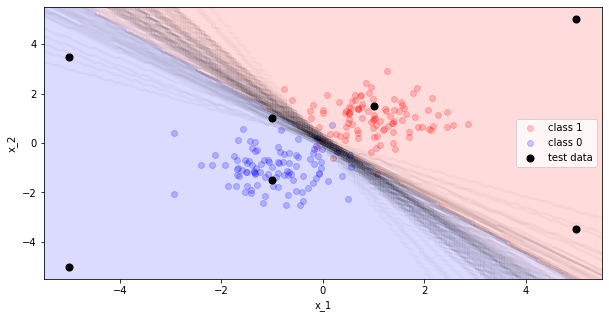

In [21]:
# Build a model for each sample in the posterior
posterior_samples_index = np.random.choice(len(samples),size=100, replace=False)
models = []

for index in posterior_samples_index:
    model_samples = samples[index, :, :]
    model = Bayesian_logistic_regression(model_samples[:,2],model_samples[:,:2].T)
    models.append(model)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_decision_boundary(x, y, models, ax, poly_degree=1,test_points=test_points, shaded= True)

What do the distribution of decision boundaries tell you about the model's predictive uncertainties for each of the test points (particularly the OOD points)?


<font color="darkblue">
    
**Interpretation:**

From the decision boundaries, it is reasonable to conclude that, the test points lie at dense decision boundaries area have high predictive uncertainty, while the test points lie further away from decision boundaries area have low predictive uncertainty. 

These decision boundaries are not enough to distinguish the OOD points from in-distribution points. For example, the test point 1,2,3,4 are far away from decision boundaries and have high confidence and low uncertainty, but they are OOD points. And the test point 5 that lie on the decision boundaries and has high epistemic uncertainty, but it is in-distribution.

**Exercise 4: (Epistemic Uncertainty from Bayesian Logistic Regression)** Since the posterior $p(\mathbf{w} | \mathcal{D}))$ is a distribution over multiple models (i.e. decision boundaries) and each model outputs a classification probability for each test data point, the posterior $p(\mathbf{w} | \mathcal{D}))$ defines a distribution of classification probabilities for each test point. The variance of the distribution over classification probabilities is one way of quantifying the amount of ***epistemic uncertainty*** - uncertainty due to lack of observed training data - of the model at a particular test point.

Estimate the average epistemic uncertainty, under the posterior $p(\mathbf{w} | \mathcal{D}))$, of the data points in the toy data set, then estimate the epistemic uncertainty of each test data point. Interpret these uncertainties, in particular, explain to what extend can the epistemic uncertainties of this Bayesian Logistic Regression model be used to distinguish in-distribution points from OOD points. 

Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior $p(\mathbf{w} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing **all** possible OOD points.

In [22]:
# Compute the average epistemic uncertainty over the trianing data
epistemic_uncertainties = []
for i in x:
    epistemic_uncertainties.append(np.var([model.predict_proba(np.array(i).reshape((1, -1))) for model in models]))
    
avg_uncertainty = np.mean(epistemic_uncertainties)
print('The estimated average epistemic uncertainty of training data points is: %.4f'%avg_uncertainty)


The estimated average epistemic uncertainty of training data points is: 0.0012


In [23]:
# Compute the epistemic uncertainty for test points
for i in test_points:
    test_epistemic_uncertainties = np.var([model.predict_proba(np.array(i).reshape((1, -1))) for model in models])
    print("for point "+ str(i) + ', the estimated epistemic uncertainty is: ' + str(round(test_epistemic_uncertainties,4)))
    

for point (-5, -5), the estimated epistemic uncertainty is: 0.0
for point (-5, 3.5), the estimated epistemic uncertainty is: 0.0124
for point (5, 5), the estimated epistemic uncertainty is: 0.0
for point (5, -3.5), the estimated epistemic uncertainty is: 0.0173
for point (-1, 1), the estimated epistemic uncertainty is: 0.0343
for point (-1, -1.5), the estimated epistemic uncertainty is: 0.0
for point (1, 1.5), the estimated epistemic uncertainty is: 0.0


Interpret these uncertainties, in particular, explain to what extend can the epistemic uncertainties of this Bayesian Logistic Regression model be used to distinguish in-distribution points from OOD points.

Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior  $p(\mathbf{w} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing all possible OOD points.


<font color="darkblue">
    
**Interpretation:**
    
The estimated average epistemic uncertainty of training data points is 0.0012.
    
For point `(-1, 1)`, the estimated epistemic uncertainty is 0.0343, which is 28 times higher than average epistemic uncertainty, as it sits on a dense region of multiple decision boundaries.
    
For point `(-5, -5)` and `(5, 5)` and `(-1, -1.5)`, `(1, 1.5)`, their epistemic uncertainty is close to zero, as they are away from decision boundary.
    
However, from the above four points, half of them are OOD data and half of them are in distribution data. It seems we are unable to distinguish OOD points with in distribution data even with epistemic uncertainty under the posterior of Bayeisan logistic regression. To obtain high epistemic uncertainties for OOD points, we may want it to be close to decision boundaries, in a sense that posterior should curve around these point or let the point sits on top of the boundary. We may need to introduce non-linearity into our decision boundary.


**Exercise 5: (Classifying OOD Data for a Toy Dataset with Bayesian Non-linear Logistic Regression)** 
Just as we can cast Bayesian Non-linear Regression as a non-linear transformation of the data followed by Bayesian Linear Regression, we can perform Bayesian Logistic Regression with non-linear decision boundaries by first applying a non-linear feature map to the data and then fitting a Bayesian Logistic Regression model on the features.

Perform Bayesian Logistic Regression using a degree 2 polynomial feature map, $\phi$, on the toy dataset. Use your implementation of HMC from In-Class Exercise 10.20 to sample from the posterior of the following Bayesian Logistic Regression model for our toy dataset:

\begin{align}
\mathbf{w} &\sim \mathcal{N}(0, 10\, \mathbf{I})\\
Y^{(n)} &\sim Ber(\text{sigm}(\mathbf{w}^\top \phi(\mathbf{X}^{(n)}) ))
\end{align}

Visualize the decision boundaries corresponding to the samples in the posterior. Are the epistemic uncertainties of this Bayesian model able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior $p(\mathbf{w} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing **all** possible OOD points.

In [24]:
# degree 2 polynomial feature map
poly = PolynomialFeatures(2, include_bias=False)
x_poly = poly.fit_transform(x)
#x_poly_new = np.hstack((x_poly, np.ones(x.shape[0]).reshape(-1,1)))
x_poly_new = np.hstack((x_poly, np.ones((x_poly.shape[0], 1), dtype=x_poly.dtype)))

In [25]:
logreg_poly = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)

logreg_poly.fit(x_poly, y)
print('Accuracy of logistic regression on training dataset is : %.4f'%logreg.score(x, y))

Accuracy of logistic regression on training dataset is : 0.9700


In [26]:
x_poly_new.shape

(200, 6)

In [27]:
### Setting up the energy functions for HMC
m = 10
D = 6
M = lambda m: m * np.identity(D)

# bernoulli pmf with y = 1 is p**1(1-p)**0=p
potential_energy = lambda q: -(sp.stats.multivariate_normal.logpdf(q, np.zeros(D), 10 * np.identity(D)) + np.sum(np.log(1-sigmoid(np.dot(q, x_poly_new[y==0,:].T)))) + np.sum(np.log(sigmoid(np.dot(q, x_poly_new[y==1,:].T)))))

kinetic_energy = lambda p: 0.5*(np.dot(p,np.matmul(M(1/m),p.T))) + 0.5*np.log(np.linalg.det(M(m))) + D/2*np.log(2*np.pi)

momentum_sampler = lambda m: np.random.multivariate_normal(mean=np.zeros(D), cov=M(m))


### Setting up hyperparameters of HMC
#leap-frog step size
step_size = 1e-1
#leap-frog steps
leapfrog_steps = 20
#number of total samples after burn-in
total_trials = 5000
#percentage of samples to burn
burn_in = int(0.1 * 5000)
#thinning factor
thinning_factor = 1


#initialize the position vector for HMC sampling with the weights of the trained neural network
position_current = np.hstack((logreg_poly.coef_.flatten(), logreg_poly.intercept_))
position_current = position_current.reshape((1, 6))
momentum_current = np.array(([0.1,0.1,0.1,0.1,0.1,0.1]))#momentum_sampler(m)



In [28]:
### Running HMC to sample from a target distribution
samples = [position_current]
accepts = 0.

for t in range(total_trials):
    position_current, momentum_current, accept = hmc(position_current, momentum_current, step_size, leapfrog_steps, potential_energy, kinetic_energy, momentum_sampler)
    samples.append(position_current)
    accepts += accept
    if t % 100 == 0 and t > 0:
        print('{} iterations, accept rate: {}'.format(t, accepts / (t + 1.)))

accept_rate = accepts / total_trials
samples = np.array(samples[burn_in::thinning_factor])

100 iterations, accept rate: 1.0
200 iterations, accept rate: 0.9950248756218906
300 iterations, accept rate: 0.9966777408637874
400 iterations, accept rate: 0.9975062344139651
500 iterations, accept rate: 0.998003992015968
600 iterations, accept rate: 0.9983361064891847
700 iterations, accept rate: 0.9985734664764622
800 iterations, accept rate: 0.9987515605493134
900 iterations, accept rate: 0.9988901220865705
1000 iterations, accept rate: 0.999000999000999
1100 iterations, accept rate: 0.9990917347865577
1200 iterations, accept rate: 0.9991673605328892
1300 iterations, accept rate: 0.9992313604919293
1400 iterations, accept rate: 0.9992862241256245
1500 iterations, accept rate: 0.9993337774816788
1600 iterations, accept rate: 0.9993753903810119
1700 iterations, accept rate: 0.9994121105232217
1800 iterations, accept rate: 0.9994447529150472
1900 iterations, accept rate: 0.9994739610731194
2000 iterations, accept rate: 0.9995002498750625
2100 iterations, accept rate: 0.99904807234650

<AxesSubplot:xlabel='x_1', ylabel='x_2'>

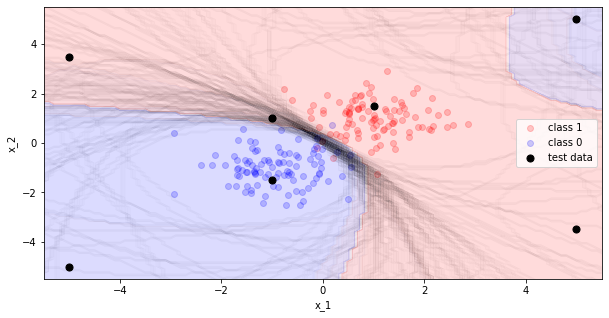

In [29]:
# Build a model for each sample in the posterior
posterior_samples_index = np.random.choice(len(samples),size=100, replace=False)
models = []

for index in posterior_samples_index:
    model_samples = samples[index, :, :]
    model = Bayesian_logistic_regression(model_samples[:,5],model_samples[:,:5].T)
    models.append(model)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plot_decision_boundary(x, y, models, ax, poly_degree=2,test_points=test_points, shaded= True)

In [30]:
# Compute the average epistemic uncertainty over the training data
epistemic_uncertainties = []
for i in x_poly:
    epistemic_uncertainties.append(np.var([model.predict_proba(np.array(i).reshape((1, -1))) for model in models]))
    
avg_uncertainty = np.mean(epistemic_uncertainties)
print('The estimated average epistemic uncertainty of training data points is: %.4f'%avg_uncertainty)

The estimated average epistemic uncertainty of training data points is: 0.0018


In [31]:
# Compute the epistemic uncertainty for test points

test_points_poly = poly.fit_transform(np.array(test_points))

for i,j in zip(test_points_poly,test_points):
    test_epistemic_uncertainties = np.var([model.predict_proba(np.array(i).reshape((1, -1))) for model in models])
    print("for point "+ str(j) + ', the estimated epistemic uncertainty is: ' + str(round(test_epistemic_uncertainties,4)))
    

for point (-5, -5), the estimated epistemic uncertainty is: 0.1333
for point (-5, 3.5), the estimated epistemic uncertainty is: 0.2084
for point (5, 5), the estimated epistemic uncertainty is: 0.1768
for point (5, -3.5), the estimated epistemic uncertainty is: 0.0839
for point (-1, 1), the estimated epistemic uncertainty is: 0.0778
for point (-1, -1.5), the estimated epistemic uncertainty is: 0.0
for point (1, 1.5), the estimated epistemic uncertainty is: 0.0


Are the epistemic uncertainties of this Bayesian model able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior  $p(\mathbf{w} | \mathcal{D}))$ . Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Logistic Regression model is capable of distinguishing all possible OOD points.

<font color="darkblue">
    
**Interpretation:**
    
From the above plot, the model with polynomial feature have nonlinear decision boundary, thus, the points distance to decision boundary varied a lot comparing to previous example.
    
The estimated average epistemic uncertainty of training data points is 0.0018.


We see that estimated epistemic uncertainty for point (1, 1.5) and (-1, -1.5) are all close to zero, showing high confidence and low uncertainty. As they are now far away from the curve decision boundary in this case. 
For the OOD points (-5, 3.5), (-5, -5) and (5, 5), they are now having higher uncertainty with 0.13 and 0.18, which is about 100 times higher than average uncertainty. It could be say that OOD points are now distinguishable from the training data since they have way higher epistemic uncertainties.
    
For point (5, -3.5), it also sit besides different decision boundaries where the posterior gives difference probabilites prediction, however, the boundary are not as messy as the region around (-5, 3.5), thus (5,-3.5) now have high variance, but lower than point (-5,3.5) based on different prediction probability. The varaince of prediction probability that rises from different decision boundaries determine the uncertainty level, and it doesn't depend on whether the data come from in distribution or OOD. It depends more on where the curves of decision boundary lie, and their relative distance to the points.
    
Still, we are unable to distinguish OOD points with in distribution data even with epistemic uncertainty under the posterior of Bayeisan logistic regression with degree 2 polynomials. 

**Exercise 6: (Classifying OOD Data for a Toy Dataset with Bootstrap Non-linear Logistic Regression)** Perform bootstrap Logistic Regression using a degree 2 polynomial feature map, $\phi$, on the toy dataset. Obtain 100 bootstrap Logistic Regression models:
`LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)`.

Visualize the decision boundaries corresponding to the samples in the bootstrap ensemble. Are the epistemic uncertainties of this ensemble able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries of the models in the ensemble. Using this geometric relationship, explain whether or not the epistemic uncertainties of our bootstrap ensemble is capable of distinguishing **all** possible OOD points.

In [32]:
def bootstrap_logreg(sample_numbers):
    models = []
    for i in range(sample_numbers):
        indices = np.random.choice(np.arange(0, len(y)), size=len(y))
        bootX, bootY = x_poly[indices], y[indices]
        logreg = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
        logreg.fit(bootX, bootY)
        models.append(logreg)
    return models

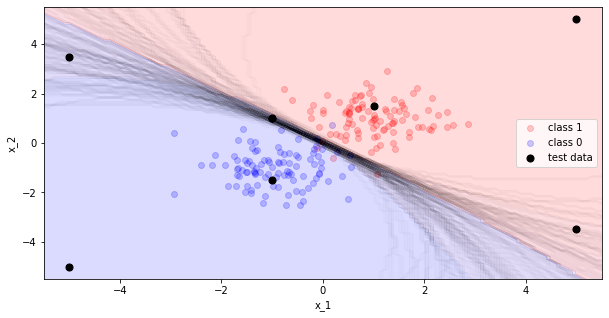

In [33]:
models = bootstrap_logreg(100)

# Visualize the decision boundaries of the bootstrap models
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax = plot_decision_boundary(x, y, models, ax, poly_degree=2, test_points=test_points, shaded = True)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.legend(loc='best')
plt.show()


In [34]:
# Compute the average epistemic uncertainty over the training data
epistemic_uncertainties = []
for i in x_poly:
    epistemic_uncertainties.append(np.var([model.predict_proba(np.array(i).reshape((1, -1))) for model in models]))
    
avg_uncertainty = np.mean(epistemic_uncertainties)
print('The estimated average epistemic uncertainty of training data points is: %.4f'%avg_uncertainty)

The estimated average epistemic uncertainty of training data points is: 0.1824


In [35]:
# Compute the epistemic uncertainty for test points

test_points_poly = poly.fit_transform(np.array(test_points))

for i,j in zip(test_points_poly,test_points):
    test_epistemic_uncertainties = np.var([model.predict_proba(np.array(i).reshape((1, -1))) for model in models])
    print("for point "+ str(j) + ', the estimated epistemic uncertainty is: ' + str(round(test_epistemic_uncertainties,4)))
    

for point (-5, -5), the estimated epistemic uncertainty is: 0.25
for point (-5, 3.5), the estimated epistemic uncertainty is: 0.1398
for point (5, 5), the estimated epistemic uncertainty is: 0.25
for point (5, -3.5), the estimated epistemic uncertainty is: 0.1787
for point (-1, 1), the estimated epistemic uncertainty is: 0.0036
for point (-1, -1.5), the estimated epistemic uncertainty is: 0.2309
for point (1, 1.5), the estimated epistemic uncertainty is: 0.2304


Are the epistemic uncertainties of this ensemble able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries of the models in the ensemble. Using this geometric relationship, explain whether or not the epistemic uncertainties of our bootstrap ensemble is capable of distinguishing all possible OOD points.

<font color="darkblue">
    
**Interpretation:**
    
From the above plot, the model with polynomial feature and bootstrap logistic regression also have nonlinear decision boundary, thus, the points distance to decision boundary varied a lot comparing to previous example.
    
The estimated average epistemic uncertainty of training data points is 0.1824.

We see that similarly, estimated epistemic uncertainty for point (-5, -5), (5, 5), (1, 1.5) and (-1, -1.5) are now all pretty high, close to `0.23-0.25`, showing low confidence and high uncertainty, regardless of whether they are in distribution or OOD. Half of them are OOD data and half of them are in distribution data. For point (-1, 1), it sits in highly densed area of all bootstrap models' decision boundary, instead of sitting somewhere where decision boundaries in the posterior gives difference probabilites prediction, thus it now become the point with lowest estimated epistemic uncertainty, with only `0.0036`. The varaince of prediction probability that rises from different decision boundaries determine the uncertainty level, and it doesn't depend on whether the data come from in distribution or OOD. It depends more on where the curves of decision boundary lie, and their relative distance to the points.
    
Still, we are unable to distinguish OOD points with in distribution data even with epistemic uncertainty under the posterior of Bayeisan logistic regression with degree 2 polynomials and bootstrap models. 

    


### Part III: Broader Impact Analysis

**Exercise 7: (The Need for Useful Uncertainties in Classification)** Explain why OOD detection may be crucial for classifiers deployed in risk-adverse applications. Be concrete: choose a real-life domain application, identify the affected communities and the real-life consequences of an incorrect classification, explain *exactly* how OOD detection can help mitigate the risk of an incorrect classification. Feel free to use the following list of articles to help construct your answer.

**Reference:**
1. [Facial Recognition Is Accurate, if You’re a White Guy](https://www.nytimes.com/2018/02/09/technology/facial-recognition-race-artificial-intelligence.html)
2. [IBM Builds a More Diverse Million-Face Dataset to Help Reduce Bias in AI](https://techcrunch.com/2019/01/29/ibm-builds-a-more-diverse-million-face-dataset-to-help-reduce-bias-in-ai/)
3. [Wrongfully Accused by an Algorithm](https://www.nytimes.com/2020/06/24/technology/facial-recognition-arrest.html)
4. [Gender imbalance in medical imaging datasets produces biased classifiers for computer-aided diagnosis](https://www.pnas.org/content/pnas/early/2020/05/19/1919012117.full.pdf)



<font color="darkblue">
    
**Answer:**

OOD detections is crucial for classifier deployed in risk-adverse application, from the linked articles above, we know that models could be used in real life domain such as facial recognition in crime detection and law enforcement. For example, a faulty facial recognition match led to a Michigan man’s arrest for a crime he did not commit. It shows that the training data does not have enough representative samples, or may be lacking data for some specific minority groups. Thus, when it comes to an OOD data point that's not seen before in training data, the model may instead give extremely confidence prediction with low uncertainty. For example, it may classify someone who the model have not seen before with high possibility and high certainty of committing crimes. 

In this case, affected communities are citizens, especially minority groups who suffered from imblanace training data problem. An incorrect classification may lead to wrong law enforcement and arrest of an innocent citizen. Thus, OOD detection could help to mitigate the risk of an incorrect classification by introducing human factors, and let an experienced human decision maker to override the model's decision.


**Exercise 8: (Comparing Bayesian and Frequnetist Epistemic Uncertainties)** In Homework #2, we saw that the epistemic uncertainties of frequentist and Bayesian uncertainties can be desirable or undesirable depending on the number of observations and the choices of hyperparameters (e.g. polynomial degree, variance of the prior in the Bayesian model, regularization strength of the models in the ensemble). For Bayesian and frequentist ensembles of classifiers, based on empirical results above, conjecture which factors affect the quality of epistemic uncertainties of Bayesian and bootstrap ensemble classifiers, respectively. Support your answer with what we know about the properties of Logistic Regression models.

In order to obtain epistemic uncertainties that can distinguish in-distribution and OOD points, what settings of hyperparameters do we need for Bayesian and bootstrap ensemble classifiers, respectively?


<font color="darkblue">
    
**Answer:**

For Bayesian Model, polynomial degree, variance of the prior in the Bayesian model, regularization strength of the models in the ensemble will all affect the level of epistemic uncertainty. By changing those parameters, the shape of decision boundaries will vary a lot (linear to non-linear etc), and thus affecting the estimate variance of predictive classification probability. By setting different values, if we could make shape of decision boundary surround in distribution points, and make OOD points further away to decision boundaries, we could probably control the estimate variance of predictive classification probability, making high uncertainty for OOD data and low uncertainty for in distribution data.
    
To be more specific,
* Lower regularization: As high regularization might penalize curvy decision boundaries with complicated parameters, however, we want our decision boundary to curve around data.
* Higher Variance on prior: As higher variance enable us to change shape of boundaries in posterior. 
* Higher degree of polynomial: To make the non-linearity curve around our data.
    
For frequentist ensembles of classifiers, there's no prior, thus only the polynominal degree, and the regularization strength of the models will affect the quality of epistemic uncertainty. The reason is similar as above, thes shape of decision boundries will change and help indicate uncertainty. And we also want higher degree of polynomial and lower regularization.

Thus, to conclude, for Bayesian classifiers, setting appropriate polynomial degree,regularization strength and prior variance can all be helpful to obtain epistemic uncertainties that can detect OOD points; 
For frequentist ensembles of classifiers, setting appropriate polynomial degree and regularization strength may help distinguish in-distribution points from OOD points. 


**Exercise 9: (Is OOD Detection Enough for Risk Adverse Applications?)** In the risk adverse real-life application you identified in Exercise 1, is accurate OOD detection enough to mitigate unwanted outcomes of deploying our model? That is, when classifiers are used in real-life applications where incorrect predictions can have disasterous consequence, what specific failure modes can these models experience? Are all of these failure modes addressed by proper detection of OOD inputs?



<font color="darkblue">
    
**Answer:**

Accurate OOD detection may not be enough to mitigate unwanted outcomes of deploying our model. When classifiers are used in real-life applications where incorrect predictions can have disasterous consequence, there are still many specific failure modes can these models experience even with detection of OOD inputs:

* Data Imbalance, Sparsity & Data Quality: If there's pre-existed systematic bias, such as minority with higher crime rate in our real life example, and there's no large pool of data to correct these bias, then the model might incorporating these bias by design, as it rises in the data collection step. This could not always be addressed even with detection of OOD inputs.

* Hidden Covariate Shift Problem: When the distribution of input data shifts between the training environment and live environment, and undetectable under OOD input detection.

* Confounding factors: Even if the model identified some major features that contributing to outcome, it could be the case that there are confounding factors that highly correlated to what features we observed. As correlation does not imply casual, we should not implement policy or law enforcement based on model performance and feature selection. There could be other factors that the model hasn't be able to capture. And depends on downstream task, we need to take special care on what level of policy we are going to enforce. This problem also could not be simply addressed by OOD input detection.  